In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def BSPrice(F,K,sig,T,r):
    ### calculates black scholes price for an option on forward
    z = np.log(F/K)/(sig*np.sqrt(T))
    price = F*norm.cdf(z + 0.5*sig*np.sqrt(T)) - K*norm.cdf(z - 0.5*sig*np.sqrt(T))
    return np.exp(-r*T)*price
    
class Currency_options:
    def __init__(self,dict_params,home_curr):
        self.dict_params = dict_params
    
    def fwd_price(self,targ_curr,home_curr,T):
        targ_fx = self.dict_params[targ_curr]["fx_rate"]/self.dict_params[home_curr]["fx_rate"]
        home_rate = self.dict_params[home_curr]["rf"]
        away_rate = self.dict_params[targ_curr]["rf"]
        return targ_fx*np.exp((home_rate - away_rate)*T)    
    
    def option_price(self,targ_curr,home_curr,T,K_cent,sig):
        fwd_price = self.fwd_price(targ_curr,home_curr,T)
        r = self.dict_params[home_curr]["rf"]
        y = self.dict_params[targ_curr]["rf"]
        option_price = BSPrice(fwd_price,K_cent*fwd_price,sig,T,r)
        return option_price

    def cross_imp_vol(self,curr_1,curr_2,correl):
        vol1 = self.dict_params[curr_1]["sig"]
        vol2 = self.dict_params[curr_2]["sig"]
        cross_vol = np.sqrt(vol1**2 + vol2**2 - 2*correl*vol1*vol2)
        return cross_vol

In [3]:
input_params = {}
input_params["USD"] = {"rf": 300e-4, 'fx_rate' : 1} ### treating USD as the universal home currency
input_params["GBP"] = {"rf": 250e-4, "sig": 0.11, "fx_rate": 1.2}
input_params["EUR"] = {"rf": 100e-4, "sig": 0.1, "fx_rate": 1.02}
T = 1
Currency_obj = Currency_options(input_params,"USD")

In [4]:
print(f"EUR forward price: {Currency_obj.fwd_price('EUR','USD',T)}")
print(f"GBP forward price: {Currency_obj.fwd_price('GBP','USD',T)}")
print(f"EUR ATMF call option price: {Currency_obj.option_price('EUR','USD',T,1,0.1)}")

EUR forward price: 1.040605366827291
GBP forward price: 1.206015025031281
EUR ATMF call option price: 0.04027043926709276


### B
As discussed in lectures, the cross implied volatility between GBP and EUR would essentially follow a cosine rule with EUR/USD and GBP/USD rates. As a conseuqeunce, the range would simply be $[|\sigma_{EUR/USD} - \sigma_{GBP/USD}|,\sigma_{EUR/USD} + \sigma_{GBP/USD}]$ (basically we have cross_vol = $\sqrt{vol_1^2 + vol_2^2 - 2*\rho vol_1 vol_2}$ which leads to the above interval given $\rho=1$ and $\rho=-1$

The call price would just translate on the interval of vols directly as call price is an increasing function of implied vol. Also, an easy way to find the call price in USD is to treat EUR as the home currency against GBP, compute the option value in EUR and then convert it to USD using the EUR/USD rate. So the interval of call options prices would be as follows:(BSPrice is the function I am using to price the options in this asst)

$[X_{EUR/USD}*BSPrice(X_{GBP/EUR}, K=X_{GBP/EUR}, \sigma^{min}_{eff},T,r_{EUR}), X_{EUR/USD}*BSPrice(X_{GBP/EUR}, K=X_{GBP/EUR}, \sigma^{max}_{eff},T,r_{EUR})]$
Plugging the corresponding values and calculating the bounds through the above functions gives the following bounds and prices

In [5]:
print(f"Cross volatility range is:[0.01,0.21]")

Cross volatility range is:[0.01,0.21]


Range of GBP/EUR option prices in USD: [(0.00466908887028729, 0.0978714031681934)]


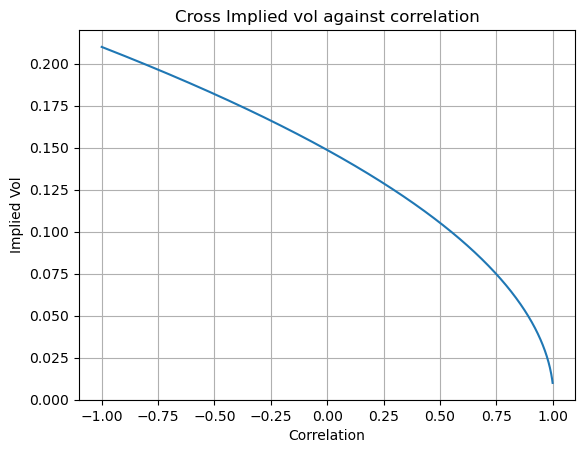

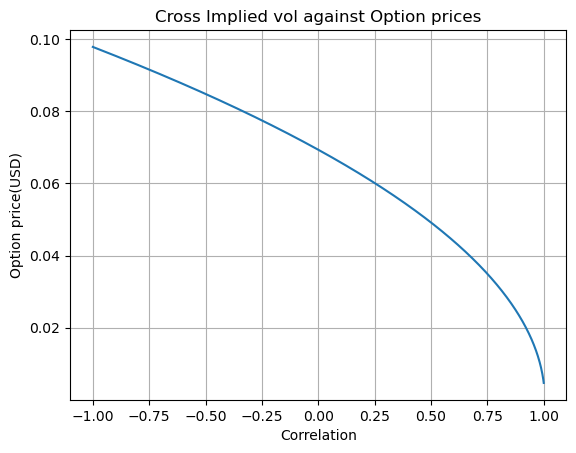

In [6]:
rho_range = np.linspace(-1,1,1000)
cross_vols = Currency_obj.cross_imp_vol("EUR", "GBP", rho_range)
GBP_EUR_options = input_params["EUR"]["fx_rate"]*Currency_obj.option_price("GBP","EUR",T,1,cross_vols)
print(f"Range of GBP/EUR option prices in USD: [{GBP_EUR_options[-1],GBP_EUR_options[0]}]")
### Cross vols
plt.title("Cross Implied vol against correlation")
plt.plot(rho_range,cross_vols)
plt.grid()
plt.xlabel("Correlation")
plt.ylabel("Implied Vol")
plt.show()
### Option prices
plt.title("Cross Implied vol against Option prices")
plt.plot(rho_range,GBP_EUR_options)
plt.grid()
plt.xlabel("Correlation")
plt.ylabel("Option price(USD)")
plt.show()

### C
Implied correlation can be calculated from the above triangle inequality we wrote which is given as below:
$\frac{\sigma_1^2 + \sigma_2^2 - \sigma_{eff}^2}{2\sigma_1\sigma_2}$

In [7]:
implied_correl = (0.1**2 + 0.11**2 - 0.08**2)/(2*0.1*0.11)
print(f"Implied Correlation between GBP/EUR is {implied_correl}")

Implied Correlation between GBP/EUR is 0.7136363636363636


### D
Clearly lower implied vol for GBP/EUR means the option here is under priced compared to the derived bounds on option price. So one can form a portfolio by shorting the expensive leg of the triangle formed by the three currencies and taking long positions in the cheaper legs. The problem now is to figure out the weighting we are supposed to give on all the legs. So consider the below portfolio:

$\Pi = \beta_1 C(GBP/EUR) + \beta_2 C(EUR/USD) - C(GBP/USD)$. Consider a case when all of the options get exercised and we have to adjust the parameters such that the net payout is $0$. 
$\implies \beta_1(GBP - F_{GBP/EUR}*EUR) + \beta_2(EUR - F_{EUR/USD}*USD) - (GBP - F_{GBP/USD}*USD) = 0$ Rearranging to corresponding currencies
\
$\implies (\beta_1 - 1)(GBP) + (\beta_2 - \beta_1 F_{GBP/EUR})EUR + (F_{GBP/USD} - \beta_2 F_{EUR/USD})USD = 0$ Setting the coefficients to zero to have no exposure
\
$\implies \beta_ 1 = 1, \beta_2 = F_{GBP/EUR}$ which automatically satisfies the third equation. Lets now look at how much we have to pay at $t=0$ for this configuration

In [11]:
GBP_EUR_fwd = Currency_obj.fwd_price("GBP","EUR",1)
P0 = input_params["EUR"]["fx_rate"]*Currency_obj.option_price("GBP", "EUR", T, 1, 0.5e-2) + GBP_EUR_fwd*Currency_obj.option_price("EUR","USD",T,1,0.1) - Currency_obj.option_price("GBP", "USD", T,1, 0.11)
print(P0)

-0.0023281215675815953


The value is $<0$ implying we would be paying negative cost today to get the portfolio. Now, at expiry based on the weights we calculated above, we would have a $0$ payout if all options get exercised(when GBP > EUR > USD). Now consider the cases when only two of the three get exercised. First being GBP is stronger than EUR, but EUR is weaker than USD. Then we end up with the case of first and third options getting exercised with net payout being $GBP - EUR - GBP + F_{GBP/USD}*USD = F_{GBP/USD}*USD - EUR > 0$ at $T$. Next, EUR is the strongest currency while dollar is the weakest, then net payout is: $F_{GBP/EUR}*EUR - F_{GBP/EUR}*F_{EUR/USD}*USD - GBP + F_{GBP/USD}*USD = F_{GBP/EUR}EUR - GBP > 0$ as EUR is the strongest currency. Also considering the cases when dollar is the strongest/stronger than GBP, the only negative component of portfolio would not be exercised and hence the overall payout would be positive. The remaining cases are trivial as if only the positive one's get exercised, then we would have a positive payout. Hence this setup would yield us an arbitrage portfolio

### E
Similar case as D except this time the GBP/EUR option is overpriced. So we can sell this overpriced option and buy the remaining two to create an arbitrage. Following similar arguments, we would setup $\Pi = \beta_1 C(GBP/USD) + \beta_2 C(USD/EUR) - C(GBP/EUR)$. Considering the case when everything gets exercised to solve for weights
\
$\implies \beta_1(GBP - F_{GBP/USD}*USD) + \beta_2(USD - F_{USD/EUR}*EUR) - (GBP - F_{GBP/EUR}*EUR) = 0$ and rearranging:
\
$\implies (\beta_1 - 1)(GBP) + (\beta_2 - \beta_1 F_{GBP/USD})USD + (F_{GBP/EUR} - \beta_2 F_{USD/EUR})EUR = 0$ Setting the coefficients to zero to have no exposure would give $\beta_1 = 1$ and $\beta_2 = F_{GBP/USD}$

In [16]:
GBP_USD_fwd = Currency_obj.fwd_price("GBP","USD",1)
P0 = -input_params["EUR"]["fx_rate"]*Currency_obj.option_price("GBP", "EUR", T, 1, 21.5e-2) + GBP_USD_fwd*Currency_obj.option_price("USD","EUR",T,1,0.1) + Currency_obj.option_price("GBP", "USD", T,1, 0.11)
print(P0)

-0.0031020013601487234


The value is $<0$ implying we would be paying negative cost today to get the portfolio. Now, at expiry based on the weights we calculated above, we would have a $0$ payout if all options get exercised(when GBP > USD > EUR). Now consider the cases when only two of the three get exercised. First being GBP is stronger than EUR, but USD is weaker than EUR. Then we end up with the case of first and third options getting exercised with net payout being $GBP - USD - GBP + F_{GBP/EUR}*EUR = F_{GBP/EUR}*EUR - USD > 0$ at $T$. Next, USD is the strongest currency while EUR is the weakest, then net payout is: $F_{GBP/USD}*USD - F_{GBP/USD}*F_{USD/EUR}*EUR - GBP + F_{GBP/EUR}*EUR = F_{GBP/USD}USD - GBP > 0$ as USD is the strongest currency. Also considering the cases when EUR is the strongest/stronger than GBP, the only negative component of portfolio would not be exercised and hence the overall payout would be positive. The remaining cases are trivial as if only the positive one's get exercised, then we would have a positive payout. Hence this setup would yield us an arbitrage portfolio